In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 5.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.4 MB/s 
     |████████████████████████████████| 26.3 MB 16.5 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [2]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from keras import backend as K

from art.attacks.evasion import CarliniL2Method, SaliencyMapMethod, ElasticNet
from art.estimators.classification import KerasClassifier

# Set the random seeds. Do not change this!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Define some constants.
NUM_CLASSES = 10
BATCH_SIZE = 32

L_0 = 'L0'
L_2 = 'L2'
L_INF = 'L_inf'
CARLINIL = 'carlinil'
ELASTIC_NET = 'elastic_net'
SALIENCY = 'saliency'

## Part 1

### You need to complete the following.

In [12]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.all_utils.normalize(x_train, axis=1)
x_test = keras.utils.all_utils.normalize(x_test, axis=1)

# convert class vectors to binary class matrices
y_train = keras.utils.all_utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.all_utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')

# Reshape the data.
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

In [14]:
# Build a training dataset for the substitute model
# Collect ten images from each dataset class (numbers 0-9)
selected_examples = []
for target_label in range(0, 10):
    count = 0
    for i in range(y_train.shape[0]):
        if y_train[i].tolist().index(1) == target_label:
            count += 1
            selected_examples.append((x_train[i, :, :], y_train[i]))
            if count == 10:
                break

# Convert selected examples to numpy array
final_train_x = list()
final_train_y = list()
for i in range(len(selected_examples)):
  final_train_x.append(selected_examples[i][0])
  final_train_y.append(selected_examples[i][1])

final_train_x = np.array(final_train_x).reshape(len(selected_examples), 1, 28, 28)
final_train_y = np.array(final_train_y)

In [20]:
# Train a CNN-based substitute model using the newly collected dataset
substitute_model = Sequential()

# Define the intermediate layers.
substitute_model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=x_train.shape[1:]))

# Adding a second convolutioinal layer
substitute_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))

# Adding Max Pooling layer
substitute_model.add(MaxPooling2D(pool_size=2, strides=2))
substitute_model.add(Dropout(0.25))

substitute_model.add(Flatten())
substitute_model.add(Dense(units=128, activation='relu'))
substitute_model.add(Dropout(0.5))
substitute_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
substitute_model.compile(loss=categorical_crossentropy, optimizer=adam_v2.Adam(learning_rate=0.01), metrics=["accuracy"])
substitute_model_classifier = KerasClassifier(model=substitute_model, clip_values=(0,1))

# Fit the model
substitute_model_classifier.fit(x_train, y_train, nb_epochs=5, batch_size=BATCH_SIZE)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 286us/sample - loss: 0.2716 - accuracy: 0.9197
Epoch 2/5
60000/60000 [==============================] - 17s 283us/sample - loss: 0.1820 - accuracy: 0.9491
Epoch 3/5
60000/60000 [==============================] - 17s 287us/sample - loss: 0.1797 - accuracy: 0.9509
Epoch 4/5
60000/60000 [==============================] - 17s 291us/sample - loss: 0.1781 - accuracy: 0.9517
Epoch 5/5
60000/60000 [==============================] - 17s 287us/sample - loss: 0.1637 - accuracy: 0.9561


    Please ONLY use the following attack methods.

In [21]:
# Define methods for generating "targetted" adversarial examples
def generate_adv_examples_CarliniL2Method(classifier, x, target_y):
    attack = CarliniL2Method(classifier, targeted=True, verbose=False)
    return attack.generate(x, target_y)

def generate_adv_examples_ElasticNet(classifier, x, target_y):
    attack = ElasticNet(classifier, targeted=True, verbose=False)
    return attack.generate(x, target_y)

def generate_adv_examples_SaliencyMapMethod(classifier, x, target_y):
    attack = SaliencyMapMethod(classifier, theta=0.1, gamma=0.1, verbose=False)
    return attack.generate(x, target_y)

In [22]:
# Build a mapping from the true label to the fake label
# For example, in the mapping below, we want the classifier to predict 0 images as 8.
label_map = {0:8, 1:9, 2:3, 3:5, 4:6, 5:7, 6:4, 7:2, 8:1, 9:0}
for k, v in label_map.items():
    assert(k != v)
assert(len(set(label_map.keys())) == 10)
assert(len(set(label_map.values())) == 10)

# Build target_y
target_y_labels = []
for i in range(final_train_y.shape[0]):
    cur_true_label = final_train_y[i].tolist().index(1)
    target_label = label_map[cur_true_label]
    target_y_labels.append(target_label)
target_y_labels = np.asarray(target_y_labels)
target_y = keras.utils.all_utils.to_categorical(target_y_labels, NUM_CLASSES)

# Generate 300 adversarial images
carlinil_adv_examples = generate_adv_examples_CarliniL2Method(substitute_model_classifier, final_train_x, target_y)
elastic_net_adv_examples = generate_adv_examples_ElasticNet(substitute_model_classifier, final_train_x, target_y)
saliency_adv_examples = generate_adv_examples_SaliencyMapMethod(substitute_model_classifier, final_train_x, target_y)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [26]:
# Calculate Misclassification Ratio (MR) for CarliniL2Method attack
predictions = substitute_model_classifier.predict(carlinil_adv_examples)
predictions_argmax = np.argmax(predictions, axis=1)
y_train_argmax = np.argmax(final_train_y, axis=1)
carlinil_mr = 1 - (np.sum(predictions_argmax == y_train_argmax) / len(final_train_y))
print('For CarliniL2Method attack, MR = {}'.format(carlinil_mr))

# Calculate Misclassification Ratio (MR) for ElasticNet attack
predictions = substitute_model_classifier.predict(elastic_net_adv_examples)
predictions_argmax = np.argmax(predictions, axis=1)
y_train_argmax = np.argmax(final_train_y, axis=1)
elastic_net_mr = 1 - (np.sum(predictions_argmax == y_train_argmax) / len(final_train_y))
print('For ElasticNet attack, MR = {}'.format(elastic_net_mr))

# Calculate Misclassification Ratio (MR) for SaliencyMapMethod attack
predictions = substitute_model_classifier.predict(saliency_adv_examples)
predictions_argmax = np.argmax(predictions, axis=1)
y_train_argmax = np.argmax(final_train_y, axis=1)
saliency_mr = 1 - (np.sum(predictions_argmax == y_train_argmax) / len(final_train_y))
print('For SaliencyMapMethod attack, MR = {}'.format(saliency_mr))

For CarliniL2Method attack, MR = 0.050000000000000044
For ElasticNet attack, MR = 0.31999999999999995
For SaliencyMapMethod attack, MR = 0.88


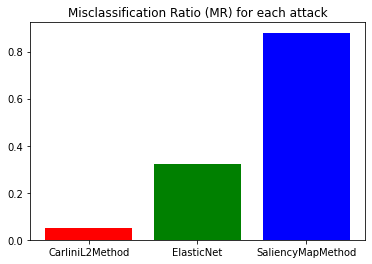

In [28]:
# Make a plot
X = ['CarliniL2Method','ElasticNet', 'SaliencyMapMethod']
Y = [carlinil_mr, elastic_net_mr, saliency_mr]
plt.bar(X, Y, color=['r', 'g', 'b'])
plt.title('Misclassification Ratio (MR) for each attack')
plt.show()
plt.close()

## Part 2

### You need to complete the following.

In [30]:
# Imports
from numpy import linalg as LA

for class_label in range(0, 10):
    print('For images of true class = {}'.format(class_label))
    norms_average = {CARLINIL: {L_0:0, L_2:0, L_INF:0}, ELASTIC_NET: {L_0:0, L_2:0, L_INF:0}, SALIENCY: {L_0:0, L_2:0, L_INF:0}}
    
    for i in range(final_train_y.shape[0]):
        cur_true_label = final_train_y[i].tolist().index(1)
        if cur_true_label == class_label:
            for attack_method in [CARLINIL, ELASTIC_NET, SALIENCY]:
                if attack_method == CARLINIL: cur_adv_examples = carlinil_adv_examples
                elif attack_method == ELASTIC_NET: cur_adv_examples = elastic_net_adv_examples
                elif attack_method == SALIENCY: cur_adv_examples = saliency_adv_examples
                x_diff = (final_train_x[i].squeeze() - cur_adv_examples[i].squeeze()).reshape(-1)
                norms_average[attack_method][L_0] += LA.norm(x_diff, 0)
                norms_average[attack_method][L_2] += LA.norm(x_diff, 2)
                norms_average[attack_method][L_INF] += LA.norm(x_diff, np.inf)
            
    print('Methods \t L0 \t L2 \t L_inf')
    for attack_method in [CARLINIL, ELASTIC_NET, SALIENCY]:
        l0_average = norms_average[attack_method][L_0] / final_train_y.shape[0]
        l2_average = norms_average[attack_method][L_2] / final_train_y.shape[0]
        linf_average = norms_average[attack_method][L_INF] / final_train_y.shape[0]
        print('{} \t {} \t {} \t {}'.format(attack_method, l0_average, l2_average, linf_average))
    print('\n')


For images of true class = 0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 19.85 	 1.0757221536729457e-08 	 1.8596021295058661e-09
elastic_net 	 34.31 	 0.22008906085072522 	 0.03607280223996066
saliency 	 22.9 	 0.06485309003081667 	 0.02100000038743019


For images of true class = 1
Methods 	 L0 	 L2 	 L_inf
carlinil 	 9.59 	 7.508240375281814e-09 	 2.500220105394746e-09
elastic_net 	 15.52 	 0.0750683226018735 	 0.012410137485389399
saliency 	 14.35 	 0.07897915049322946 	 0.021000000461935998


For images of true class = 2
Methods 	 L0 	 L2 	 L_inf
carlinil 	 18.38 	 1.1302592047055778e-08 	 2.7562740323450186e-09
elastic_net 	 26.4 	 0.06904113621844116 	 0.015450153842673224
saliency 	 22.67 	 0.07663124528038438 	 0.019000000491140187


For images of true class = 3
Methods 	 L0 	 L2 	 L_inf
carlinil 	 16.53 	 1.0368768932429441e-08 	 2.6462905866608823e-09
elastic_net 	 19.42 	 0.05696082528777795 	 0.008697615828044273
saliency 	 20.26 	 0.07790250940870927 	 0.024000000655651093


For 

## Part 3

### You need to complete the following.

In [33]:
# Imports

# Reload the trained model from HW#3 Problem 4
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle

# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    target_net = u.load()

In [34]:
def predict_using_target_net(x, verbose=False):
    x = x.squeeze().reshape(-1, 1)
    outputs = target_net.feedforward(x)
    predictions = np.argmax(outputs)
    if verbose:
        print('Network output: \n' + str(np.round(outputs, 2)) + '\n')
        print('Network prediction: ' + str(predictions) + '\n')
        print('Actual image: ')
    
        # Draw the image
        plt.imshow(x.reshape((28,28)), cmap='Greys')
        plt.show()
    return predictions

In [35]:
# Evaluate whether adversarial examples generated with the substitute model will transfer to the target model
adv_examples = list()
for attack_method in [CARLINIL, ELASTIC_NET, SALIENCY]:
    if attack_method == CARLINIL: adv_examples = carlinil_adv_examples 
    elif attack_method == ELASTIC_NET: adv_examples = elastic_net_adv_examples
    elif attack_method == SALIENCY: adv_examples = saliency_adv_examples
    predictions = list()
    for adv_example in adv_examples:
      target_net_prediction = predict_using_target_net(adv_example)
      predictions.append(target_net_prediction)
    predictions = np.asarray(predictions)
    y_train_argmax = np.argmax(final_train_y, axis=1)
    mr = 1- (np.sum(predictions == y_train_argmax) / len(final_train_y))
    print('For {}, Misclassification Ratio = {}\n'.format(attack_method, mr))

For carlinil, Misclassification Ratio = 0.16000000000000003

For elastic_net, Misclassification Ratio = 0.27

For saliency, Misclassification Ratio = 0.18999999999999995



## Part 4

### You need to complete the following.

In [3]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [37]:
# Re-load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.all_utils.normalize(x_train, axis=1)
x_test = keras.utils.all_utils.normalize(x_test, axis=1)

nb_trains = x_train.shape[0]
nb_tests = x_test.shape[0]

In [5]:
# ANN model
ann_parameters = {
'hidden_layer_sizes': [(100), (100,100)]
}
ann_clf = GridSearchCV(MLPClassifier(), ann_parameters)
#x_train_small = x_train[0:10000]
#y_train_small = y_train[0:10000]
ann_clf.fit(x_train.reshape(-1,784), y_train)
print(ann_clf.best_score_)

0.9717166666666666


In [6]:
# SVM model
svm_parameters = {
    'kernel': ['rbf'],
    'C': [1, 10]
}
svm_clf = GridSearchCV(SVC(), svm_parameters)
svm_clf.fit(x_train.reshape(-1,784), y_train)
print(svm_clf.best_score_)

0.9795666666666667


In [7]:
# Logistic Regression model

# As Solver lbfgs supports only `l2` or `none` penalties and not the `l1` penalty, so explicitly mentioning the solvers along with 
# different penalty in the `lr_parameters`.
# Reference doc from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr_parameters = [
  {'multi_class': ['auto'], 'C': [1, 10], 'penalty': ['l1'], 'solver': ['liblinear']},
  {'multi_class': ['auto'], 'C': [1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']},
 ]

lr_clf = GridSearchCV(LogisticRegression(max_iter=500), lr_parameters)
lr_clf.fit((x_train[0:10000]).reshape(-1,784), y_train[0:10000])
print(lr_clf.best_score_)

0.9103


In [8]:
# kNN
knn_parameters = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance']
}
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_parameters)
knn_clf.fit(x_train.reshape(-1,784), y_train)
print(knn_clf.best_score_)

0.9588333333333333


In [9]:
# Naive Bayes
naive_bayes_parameters = {
    'var_smoothing': [1e-3, 1e-2, 1e-1]
}
naive_bayes_clf = GridSearchCV(GaussianNB(), naive_bayes_parameters)
naive_bayes_clf.fit(x_train.reshape(-1,784), y_train)
print(naive_bayes_clf.best_score_)

0.7967000000000001


In [10]:
# Voting classifiers
voting_clf = VotingClassifier(estimators=[
                                ('naive_bayes', GaussianNB()),
                                ('ann', MLPClassifier()),
                                ('lr', LogisticRegression(max_iter=500)),
                               ], voting='soft')

params = {
          'naive_bayes__var_smoothing': [1e-3, 1e-2, 1e-1],
          'lr__C': [1, 10],
          'ann__hidden_layer_sizes': [(100), (100,100)]}

voting_clf = GridSearchCV(voting_clf, params)
voting_clf.fit((x_train[0:10000]).reshape(-1,784), y_train[0:10000])
print(voting_clf.best_score_)

0.9256


In [40]:
classifier_names = ['ANN', 'SVM', 'LRC', 'kNN', 'NBC', 'VoC']
classifiers = [ann_clf, svm_clf, lr_clf, knn_clf, naive_bayes_clf, voting_clf]
print('Methods \t Test Acc \t Carlinil MR \t ElasticNet MR \t Saliency MR')
for i in range(len(classifiers)):
    test_acc = classifiers[i].score(x_test.reshape(-1,784), y_test)
    carlinil_acc = np.sum(classifiers[i].predict(carlinil_adv_examples.reshape(-1,784)) == np.argmax(final_train_y)) / len(carlinil_adv_examples)
    elasticnet_acc = np.sum(classifiers[i].predict(elastic_net_adv_examples.reshape(-1,784)) == np.argmax(final_train_y)) / len(elastic_net_adv_examples)
    saliency_acc = np.sum(classifiers[i].predict(saliency_adv_examples.reshape(-1,784)) == np.argmax(final_train_y)) / len(saliency_adv_examples)
    print('{} \t\t {} \t\t {} \t\t {} \t\t {}'.format(classifier_names[i], str(test_acc), str(carlinil_acc), str(elasticnet_acc), str(saliency_acc)))

Methods 	 Test Acc 	 Carlinil MR 	 ElasticNet MR 	 Saliency MR
ANN 		 0.976 		 0.1 		 0.11 		 0.1
SVM 		 0.9817 		 0.1 		 0.06 		 0.1
LRC 		 0.9126 		 0.1 		 0.06 		 0.1
kNN 		 0.9622 		 0.1 		 0.17 		 0.1
NBC 		 0.8073 		 0.1 		 0.07 		 0.1
VoC 		 0.9245 		 0.11 		 0.06 		 0.11
